# Weather Analysis project

## Objectives are to build a series of scatter plots to showcase the following relationships:

+ Temperature (ºF) vs. Latitude
+ Humidity (%) vs. Latitude
+ Cloudiness (%) vs. Latitude
+ Wind Speed (mph) vs. Latitude

Plots are created for about 500 unique random cities.

## Plan of Approach

First, random geographical coordinates (latitude/longitude) will be created.
Next, the Python citipy module will be used to grab the nearest city and country based on geopraphical coordinates.
We then use the Current weather data API from OpenWeatherMap to collect weather data.
Finally, weather data is translated into above mentioned plots.

#### Notes

**API Key**

This script uses a (free) API key available on request at the OpenWeatherMap web site (https://openweathermap.org/)
The key is stored in a separate (py) file called config.py
The key is empty, you'll have to adapt the config.py file and enter your own API key.

**City/country combinations using the OpenWeatherMap API**

I noticed that if a city/country combinations exists more than once, the OpenWeatherMap API key will only grab the first occurence. For instance, there's multiple towns called Amsterdam in the United States, only one will be collected.

**Date of analysis**

Weather data was selected on April 2th 2018.

## Analysis

As the collected weather data is just a snapshot (weather at a specific moment), we can't really draw conclusions.
To do an reliable analysis, one would need to collect historical weather data and account for (among others):

+ seasonal fluctuations
+ climate zones
+ unusual weather occurences
+ latitude zones (it likely will be naturally colder near the poles)

**Temperature (ºF) vs. Latitude**

Tempature seems to be higher between latitude 0 and 30 (North-Western hemisphere)

**Humidity (%) vs. Latitude**

Humidity seems to be higher on the Northern hemisphere. Might be due to seasons (plots were created in April hence early spring on the Northern hemisphere and late fall on the Southern hemisphere).

**Cloudiness (%) vs. Latitude**

There doesn't seem to be a correlation between cloudiness and latitude.

**Wind Speed (mph) vs. Latitude**

There doesn't seem to be a correlation between wind speed and latitude.
Prevailing wind speeds are betwwen 0 and 10 miles per hour.

In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from citipy import citipy
import random
import pycountry
import time
from config import owm_key # key is empty string, you'll have to (generate and) enter your own API key
from datetime import datetime
import os

## Initialization API request

In [2]:
# OpenWeatherMap (OWM)
# We'll be using the OWM Current Weather data API
base_url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"
# Build partial query URL
query_url = f"{base_url}appid={owm_key}&units={units}&q="
# Hide API key
start = query_url.find("appid=") + len("appid=") # start position of API key
key_length = len(owm_key)
url_hidden_key = query_url.replace(query_url[start:start+key_length],key_length*"*")

## Data preparation

In [3]:
# Delete files with the same name + extension as we'll later use for our 
# - log files
# - weather data file

# Grab current directory, define variables for files to remove
current_dir = os.getcwd() + "/"
log_file = "log file.txt"
weather_file = "Weather data.csv"

## Delete files, show error if file doesn't exist
if os.path.isfile(current_dir + log_file):
    os.remove(log_file)
else:
    print("Error: %s file not found" % log_file)
    
if os.path.isfile(current_dir + weather_file):
    os.remove(weather_file)
else:
    print("Error: %s file not found" % weather_file)

Error: log file.txt file not found
Error: Weather data.csv file not found


In [4]:
# Initialize empty dataframes
cities_df = pd.DataFrame()
weather_df = pd.DataFrame()

In [5]:
# Create random latitude and longitude data
def random_coord():
    xrange = 50
    cities_df["Lat"] = [np.random.uniform(-90,90) for x in range(xrange)]
    cities_df["Lon"] = [np.random.uniform(-180,180) for x in range(xrange)]

In [6]:
# Define function to loop through citipy and remove duplicates
def get_citipy_data():
    for index, row in cities_df.iterrows():
        cities_df.loc[index,"City"] = citipy.nearest_city(row["Lat"],row["Lon"]).city_name
        cities_df.loc[index,"Country Code"] = citipy.nearest_city(row["Lat"],row["Lon"]).country_code
    # Remove any duplicates except for the first occurence based on the combination City/Country Code
    cities_df.drop_duplicates(["City","Country Code"])
    # Remove random coordinates
    # cities_df.drop(["Lat","Lon"], inplace=True, axis=1)
    #cities_df.to_csv("country list.csv", index = False)

In [7]:
# Define function to map country code with country name
def get_countries():
    countries = {}
    for country in pycountry.countries:
        countries[country.name] = country.alpha_2

    for index, row in cities_df.iterrows():
        for key, val in countries.items():
            if val.upper() == row["Country Code"].upper():
                cities_df.loc[index, "Country Name"] = key

In [8]:
# Function to collect weather data
# These data will be written to a log file:
# - in case weather data is found: requested url, city id, city name 
# - in case no weather data is found: requested url, city name
# - in case the request failed: a message stating that the request failed including possible causes
def get_weather():
    with open ("log file.txt",'a') as logfile:
        #logfile.write("")
        for row in cities_df.itertuples():
            #params = {row["City"]:row["Country Code"]}
            try:
                response = requests.get(query_url + cities_df.loc[row.Index, "City"] + "," + cities_df.loc[row.Index, "Country Code"]).json()
                #response = requests.get(query_url, params = params).json()
            except:
                logfile.write("Unable to handle request (server might be down, no internet connection, connection refused)")
                continue
            try:
                cities_df.loc[row.Index, "Lat"] = response['coord']['lat']
                cities_df.loc[row.Index, "Lon"] = response['coord']['lon']
                cities_df.loc[row.Index, "Temp (ºF)"] = response['main']['temp']
                cities_df.loc[row.Index, "Humidity (%)"] = response['main']['humidity']
                cities_df.loc[row.Index, "Cloudiness (%)"] = response['clouds']['all']
                cities_df.loc[row.Index, "Wind Speed (mph)"] = response['wind']['speed']
                cities_df.loc[row.Index, "Time of retrieval"] = response['dt']
                logfile.write("City number: " + str(response['id']) + ", " + "city name: " + str(response['name'])+ "\n" 
                + "Requested url: " + str(url_hidden_key + cities_df.loc[row.Index, "City"] + "," + cities_df.loc[row.Index, "Country Code"]) + "\n")
            except:
                logfile.write("No weather data found for " + cities_df.loc[row.Index, "City"] + "\n" 
                + "Requested url: " + str(url_hidden_key + cities_df.loc[row.Index, "City"] + "," + cities_df.loc[row.Index, "Country Code"]) + "\n")
                continue
            #time.sleep(1)

## Collect weather data

In [9]:
# Loop until we have collected at least unique 500 cities with weather data
# As we defined a range of 50 in get_citipy_data, the total number of unique cities will be between 500 and 550
x = 0
while x < 500:
    # run functions
    random_coord()
    get_citipy_data()
    get_countries()
    get_weather()
    # add current cities_df dataframe to 
    weather_df = pd.concat([weather_df, cities_df], ignore_index=True)
    # Remove rows with null values
    weather_df = weather_df.dropna(how='any',axis=0) #axis=0 -> drops rows, axis=1 -> drops columns
    # Remove duplicates except for the first occurence based on the combination latitude/longitude
    weather_df = weather_df.drop_duplicates(["Lat","Lon"])
    x = len(weather_df) # total number of unique cities we collected weather data for so far  

In [10]:
#Convert unix date format
weather_df.is_copy = False
weather_df["Time of retrieval"] = [datetime.fromtimestamp(d) for d in weather_df["Time of retrieval"]]
weather_df.head()

,Lat,Lon,City,Country Code,Country Name,Temp (ºF),Humidity (%),Cloudiness (%),Wind Speed (mph),Time of retrieval
0,40.71,112.04,zhuhai,cn,China,42.80,33.0,20.0,13.42,2018-04-02 11:00:00
1,25.62,79.18,gursarai,in,India,78.72,35.0,0.0,9.44,2018-04-02 11:50:10
2,47.66,-52.73,torbay,ca,Canada,41.00,48.0,20.0,34.45,2018-04-02 11:00:00
3,-53.16,-70.91,punta arenas,cl,Chile,52.65,81.0,90.0,11.41,2018-04-02 11:00:00
4,15.59,32.54,khartoum,sd,Sudan,89.60,6.0,0.0,12.75,2018-04-02 11:30:00


In [11]:
# Export collected weather data to csv file
weather_df.to_csv("Weather data.csv", encoding = "utf-8-sig", index = False)

## Create plots

In [13]:
# Define default tick locations for our plots
min_lat = weather_df["Lat"].min()//10*10
max_lat = weather_df["Lat"].max()//10*10+15

tick_locations = np.arange(min_lat -10, max_lat +10, 10)

### Temperature (ºF) vs. Latitude

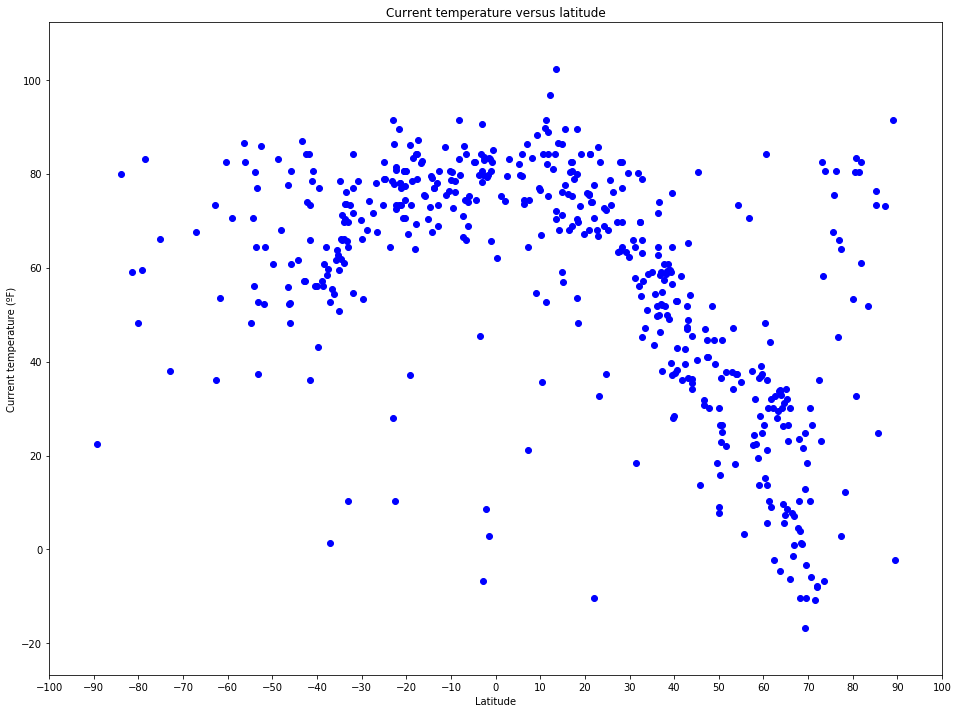

In [15]:
# Create scatter plot current Temperature (ºF) vs. Latitude
plt.xlim(min_lat, max_lat)
plt.ylim(weather_df["Temp (ºF)"].min() - 10, weather_df["Temp (ºF)"].max()+10)

plt.xlabel("Latitude")
plt.ylabel("Current temperature (ºF)")
plt.title("Current temperature versus latitude")

x = weather_df["Lat"]
y = weather_df["Temp (ºF)"]
plt.scatter(x, y, color = "blue")
             
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["figure.figsize"] = [16,12]
plt.xticks(tick_locations)
plt.show()

### Humidity (%) vs. Latitude

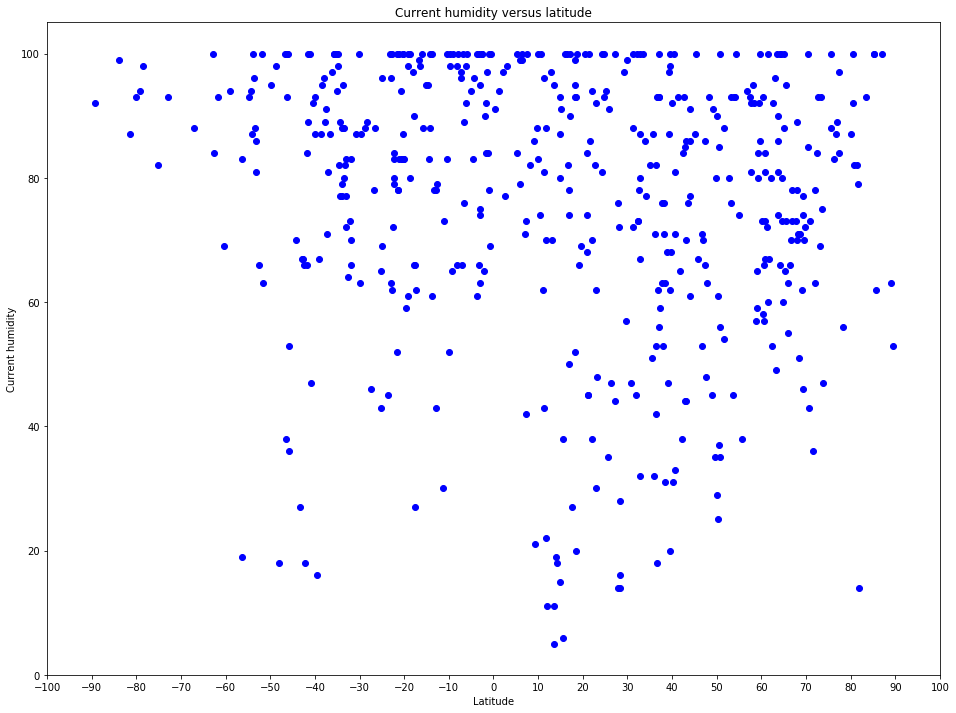

In [16]:
# Create scatter plot current Humidity (%) vs. Latitude
plt.xlim(min_lat, max_lat)
plt.ylim(weather_df["Humidity (%)"].min() - 5, weather_df["Humidity (%)"].max()+5)
plt.xlabel("Latitude")
plt.ylabel("Current humidity")
plt.title("Current humidity versus latitude")

x = weather_df["Lat"]
y = weather_df["Humidity (%)"]
plt.scatter(x, y, color = "blue")
             
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["figure.figsize"] = [16,12]
plt.xticks(tick_locations)
plt.show()

### Cloudiness (%) vs. Latitude

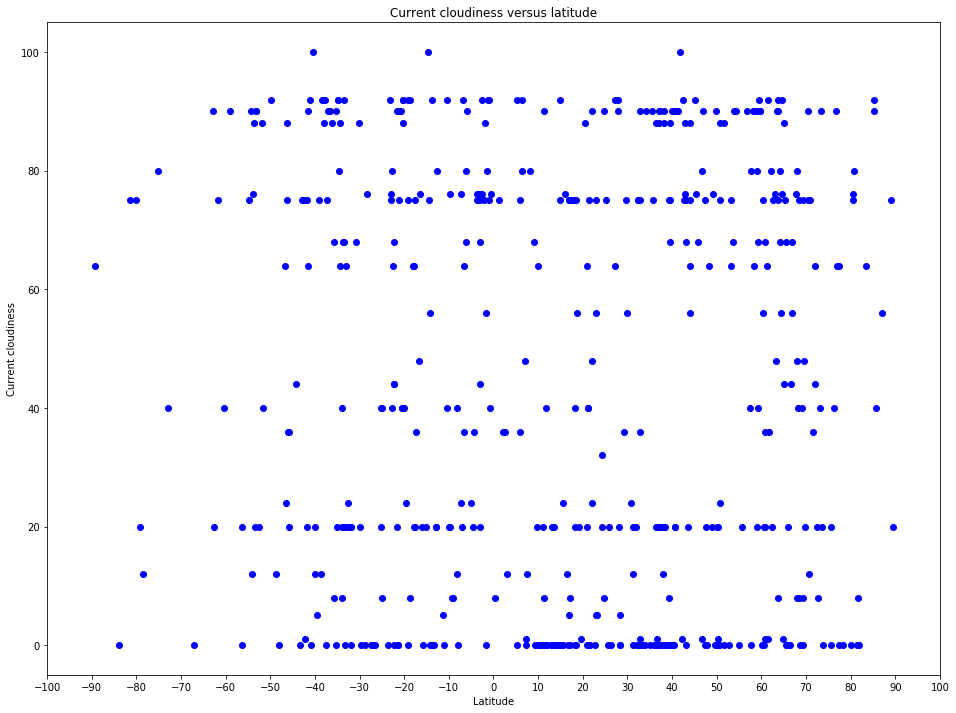

In [17]:
# Create scatter plot current Cloudiness (%) vs. Latitude
plt.xlim(min_lat, max_lat)
plt.ylim(weather_df["Cloudiness (%)"].min() - 5, weather_df["Cloudiness (%)"].max()+5)
plt.xlabel("Latitude")
plt.ylabel("Current cloudiness")
plt.title("Current cloudiness versus latitude")

x = weather_df["Lat"]
y = weather_df["Cloudiness (%)"]
plt.scatter(x, y, color = "blue")
             
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["figure.figsize"] = [16,12]
plt.xticks(tick_locations)
plt.show()

### Wind Speed (mph) versus Latitude

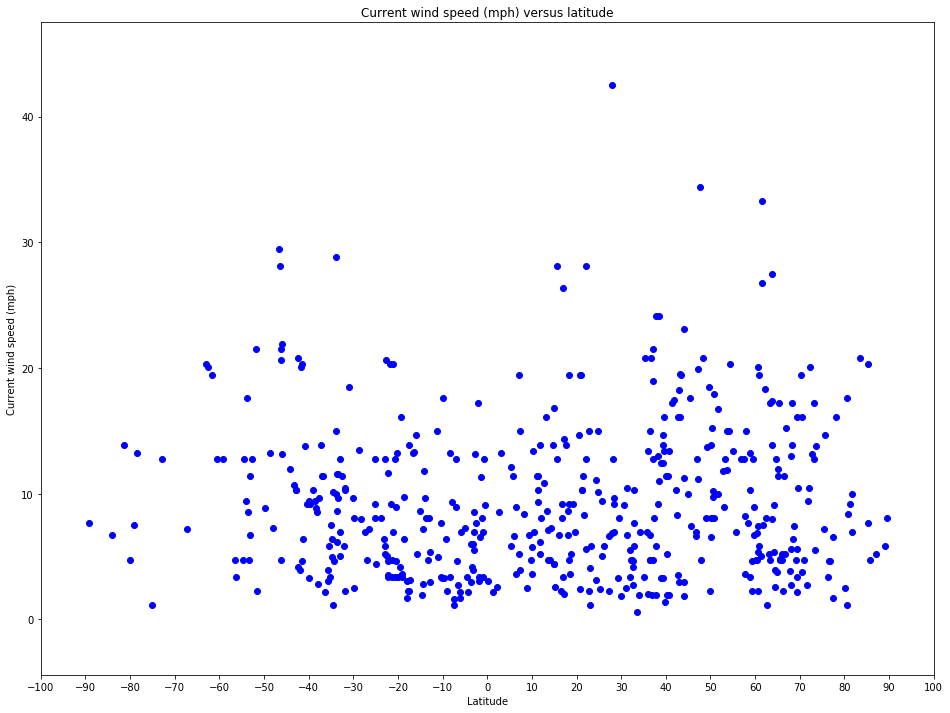

In [18]:
# Create scatter plot current Wind Speed (mph) versus Latitude
plt.xlim(min_lat, max_lat)
plt.ylim(weather_df["Wind Speed (mph)"].min() - 5, weather_df["Wind Speed (mph)"].max()+5)

plt.xlabel("Latitude")
plt.ylabel("Current wind speed (mph)")
plt.title("Current wind speed (mph) versus latitude")

x = weather_df["Lat"]
y = weather_df["Wind Speed (mph)"]
plt.scatter(x, y, color = "blue")
             
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["figure.figsize"] = [16,12]
plt.xticks(tick_locations)
plt.show()